<a href="https://colab.research.google.com/github/joee2711/Objectdetection/blob/main/HatchFast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Hello")

Hello


In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 1.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15297 (delta 7), reused 7 (delta 1), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 7.88 MiB/s, done.
Resolving deltas: 100% (11118/11118), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.0 MB/s eta 0:00:00
  Prep

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
import json
import cv2

In [5]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("Data", {}, "/content/drive/MyDrive/HatchFast/_annotations.json", "/content/drive/MyDrive/HatchFast/train")

In [8]:
metadata = MetadataCatalog.get("Data")

In [9]:
metadata

namespace(name='Data',
          json_file='/content/drive/MyDrive/HatchFast/_annotations.json',
          image_root='/content/drive/MyDrive/HatchFast/train',
          evaluator_type='coco')

In [10]:
dataset_dicts = DatasetCatalog.get("Data")

WARNING [01/04 13:48:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/04 13:48:38 d2.data.datasets.coco]: Loaded 240 images in COCO format from /content/drive/MyDrive/HatchFast/_annotations.json


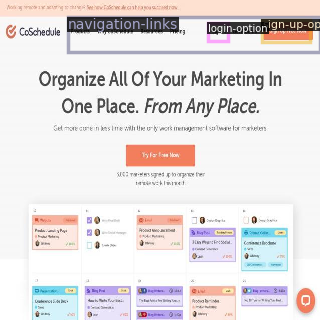

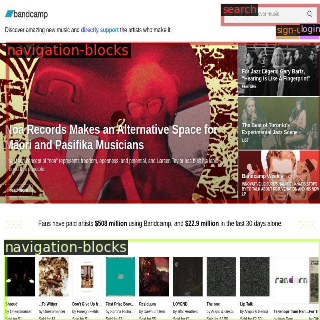

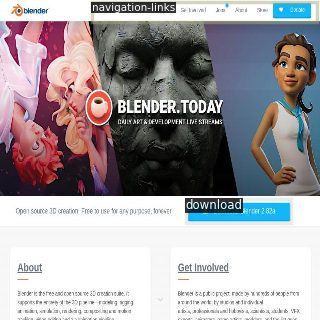

In [11]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [20]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
# "COCO-Detection/faster_rcnn_R_50_C4_1x": "137257644/model_final_721ade.pkl

cfg = get_cfg()
cfg.merge_from_file(
    "/content/detectron2/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"
)
# /content/detectron2/detectron2/model_zoo/configs/COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml
cfg.DATASETS.TRAIN = ("Data",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_C4_1x/137257644/model_final_721ade.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = (
    300
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 30  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# CUDA_LAUNCH_BLOCKING=1
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/04 14:37:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_721ade.pkl: 136MB [00:00, 155MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[01/04 14:37:57 d2.engine.train_loop]: Starting training from iteration 0
[01/04 14:38:10 d2.utils.events]:  eta: 0:02:34  iter: 19  total_loss: 2.57  loss_cls: 1.646  loss_box_reg: 0.4406  loss_rpn_cls: 0.3019  loss_rpn_loc: 0.1205    time: 0.5600  last_time: 0.5494  data_time: 0.0483  last_data_time: 0.0083   lr: 0.0012854  max_mem: 3353M
[01/04 14:38:21 d2.utils.events]:  eta: 0:02:23  iter: 39  total_loss: 1.958  loss_cls: 0.8039  loss_box_reg: 0.6691  loss_rpn_cls: 0.2129  loss_rpn_loc: 0.1736    time: 0.5571  last_time: 0.5312  data_time: 0.0060  last_data_time: 0.0063   lr: 0.0026174  max_mem: 3354M
[01/04 14:38:32 d2.utils.events]:  eta: 0:02:11  iter: 59  total_loss: 1.671  loss_cls: 0.7682  loss_box_reg: 0.6557  loss_rpn_cls: 0.1459  loss_rpn_loc: 0.1599    time: 0.5496  last_time: 0.5267  data_time: 0.0060  last_data_time: 0.0053   lr: 0.0039494  max_mem: 3354M
[01/04 14:38:42 d2.utils.events]:  eta: 0:01:57  iter: 79  total_loss: 1.647  loss_cls: 0.6012  loss_box_reg: 0.640

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("Data", )
predictor = DefaultPredictor(cfg)

[01/04 14:59:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


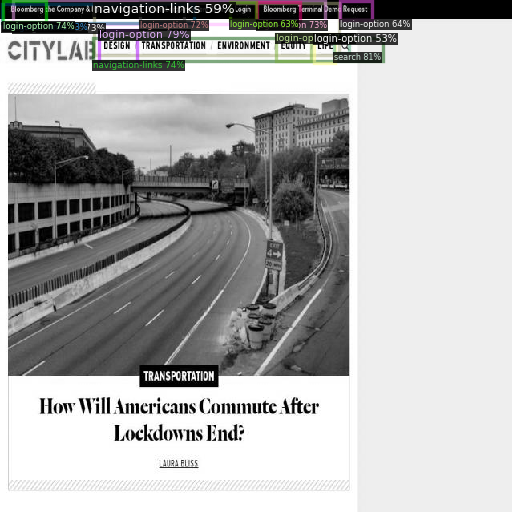

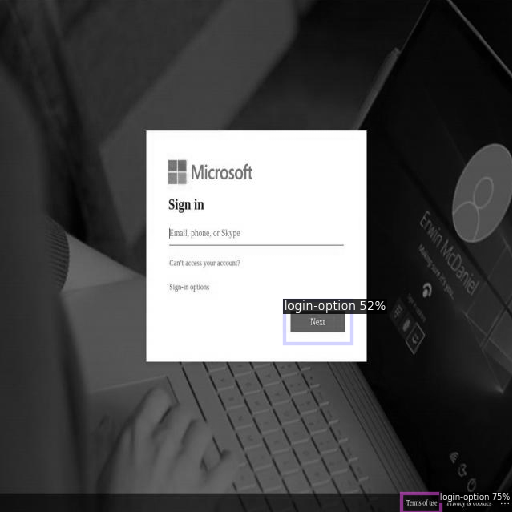

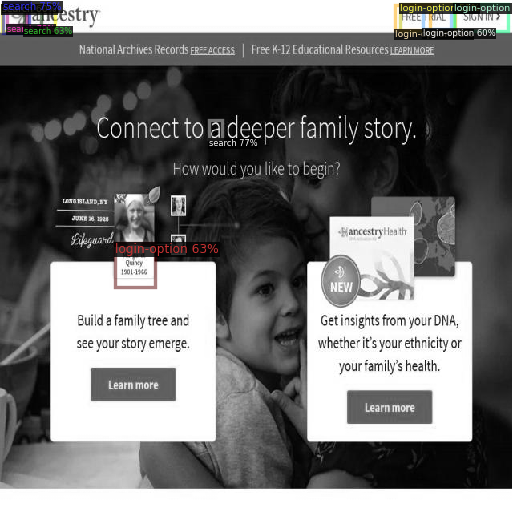

In [22]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])